In [35]:
#%pip install tensorflow xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
#%conda install -c conda-forge seaborn pandas numpy matplotlib scikit-learn statsmodels

In [17]:
import pandas as pd
import numpy as np

### Ensemble model

- Use the **wisdom of crowd** -> law of large numbers
- But, model must be independent to each other
- One way to perform ensemble model is to train multiple models and aggregate the result
- Another way is to use the same algorithm, but create multiple subset(**Bagging** or **Pasting**) from the train set, train the model differently, and then aggregate the result


### Bagging and Pasting

- Bagging: Sample w/o replacement
- Pasting: Sample w/ replacement
- We can apply parallel computing
- If we use bagging, some sample would never be contained in the train set. So, we call those sample call **OOB**, and use for validation set


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise = 0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators= 500,
                            max_samples=100,
                            n_jobs= -1, # number of CPU
                            bootstrap= True, # sample w/ replacement
                            oob_score= True, # Use OOB scoring
                            random_state=42)

bag_clf.fit(X_train,y_train)
print(bag_clf.oob_score_)
bag_clf.predict(X_test)

0.9253333333333333


array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

# 2. Random Forest

- Ensemble model of descision tree with Bagging or Pasting
- Random Forest is not focusing on finding the best feature to split from "all" features, rather it focuses on finding
  the best feature from randomly selected featues -> reduces the variance and generate more diverse tree
- Random Forest basically choose square root of N features for each tree


### 2.1 Basic Model


In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, # number of models to generate
                                 max_leaf_nodes=16, # depth of the model
                                 class_weight = 'balanced', # to reduce the imbalancity 
                                 n_jobs = -1, #
                                 random_state=42
                                 )

### 2.2 Feature Importance


In [21]:
iris.data.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


<Axes: >

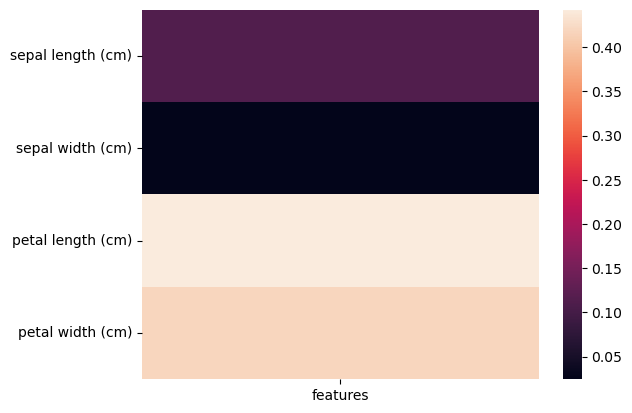

In [34]:
from sklearn.datasets import load_iris
import seaborn as sns

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, # number of models to generate
                                 max_leaf_nodes=16, # depth of the model
                                 n_jobs = -1, #
                                 random_state=42
                                 )
rnd_clf.fit(iris.data, iris.target)

# Print Feature importance
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score,2), name)

ft_imp_df = pd.DataFrame(rnd_clf.feature_importances_, index = iris.data.columns, columns = ['features'])
sns.heatmap(ft_imp_df)

# 3. Boosting

- Connect multiple weak estimators to generate a strong estimator
- Train estimator by supplementing weak estimators


### 3.1 XGBoost

- n_estimators: # of decision trees, by default 100
- learning_rate: by default 0.3
- max_depth: max depth of the tree, one of the regulation parameters
- subsample: ratio of the training sample. By default 1.0, the whole sample.
- colsample_bytree: ratio of the features usage for training. By default 1.0. one of the regulation parameters.


In [45]:
import xgboost as xgb
from sklearn.metrics import f1_score

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,        
    learning_rate=0.1,       
    max_depth=3,             
    subsample=0.8,           
    colsample_bytree=0.8, 
    n_jobs=-1,
    random_state=42          
)

# Train
xgb_clf.fit(X_train, y_train)
# Predict
y_pred = xgb_clf.predict(X_test)
# Scoreing
accuracy = f1_score(y_test, y_pred, average='macro')
print(f"XGBoost f1_score: {accuracy:.4f}")

# Compare with rf
rnd_clf = RandomForestClassifier(n_estimators=100, # number of models to generate
                                 max_depth= 3,
                                 max_leaf_nodes=16, # depth of the model
                                 n_jobs = -1, 
                                 random_state=42
                                 )
# Train
xgb_clf.fit(X_train, y_train)
# Predict
y_pred = xgb_clf.predict(X_test)
# Scoreing
accuracy = f1_score(y_test, y_pred, average='macro')
print(f"Random Forest f1_score: {accuracy:.4f}")

XGBoost f1_score: 1.0000
Random Forest f1_score: 1.0000


### 3.2 LightGBM

- Similar to XGBoost, but more suitable for large dataset


In [48]:
import lightgbm as lgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로드 및 분할
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,      # 트리 개수
    learning_rate=0.1,     # 학습률
    max_depth=4,           # 트리의 최대 깊이>
    num_leaves=16,         # 최대 리프 노드 수
    subsample=0.8,         # 각 트리에 사용할 샘플 비율
    colsample_bytree=0.8,  # 각 트리에 사용할 특성 비율
    random_state=42,       # 난수 시드 고정
    verbose = -1
)

# 모델 학습
lgb_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = lgb_clf.predict(X_test)
accuracy = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 1.0000
